In [1]:
import harmonica as hm
import matplotlib.pyplot as plt
import numpy as np
import verde as vd

from magali._inversion import MagneticDipoleBz, MagneticMomentBz
from magali._synthetic import dipole_bz
from magali._units import (
    coordinates_micrometer_to_meter,
    meter_to_micrometer,
    nanotesla_to_tesla,
    tesla_to_nanotesla,
)

In [2]:
dipole_coordinates = (500, 500, -15)
true_inclination = 30
true_declination = 40
true_intensity = 5e-11

In [3]:
coordinates = vd.grid_coordinates(
    region=[490, 510, 490, 510],
    spacing=1,
    extra_coords=5,
)
true_intensity = 5e-10
true_moment = hm.magnetic_angles_to_vec(
    inclination=true_inclination,
    declination=true_declination,
    intensity=true_intensity,
)

data = dipole_bz(coordinates, dipole_coordinates, true_moment)
linear_model = MagneticMomentBz((499, 499, -14))
linear_model.fit(coordinates, data)
print("True location:", dipole_coordinates)
print("True moment:", true_moment)
tuple(linear_model.dipole_moment_)

True location: (500, 500, -15)
True moment: (np.float64(2.783351996132097e-10), np.float64(3.317069740844692e-10), np.float64(-2.4999999999999996e-10))


(np.float64(1.998503632982814e-10),
 np.float64(2.4551824249859465e-10),
 np.float64(-2.5095731103654353e-10))

In [4]:
model = MagneticDipoleBz((499, 499, -14) + tuple(linear_model.dipole_moment_))

model.fit(coordinates, data)

print("Recovered location:", meter_to_micrometer(model.location_))
print("Recovered moment:", model.dipole_moment_)
print("True location:", dipole_coordinates)
print("True moment:", true_moment)

(np.float64(1.998503632982814e-10), np.float64(2.4551824249859465e-10), np.float64(-2.5095731103654353e-10))
(np.float64(495.0), np.float64(495.0), np.float64(-14.0))
[ 2.74361134e-11  7.91207880e-11 -3.16161276e-10]


ValueError: Invalid magnetic moments with '0' elements. Magnetic moments vectors should have 3 components.

In [4]:
model.misfit

[np.float64(7.376371744083828e+25),
 np.float64(1.1225931274945406e+16),
 np.float64(1.1225931274945406e+16)]

In [10]:
params = tuple(
    [
        1,
        2,
        3,
    ]
)
moment = tuple([4, 5, 6])
params + moment

(1, 2, 3, 4, 5, 6)

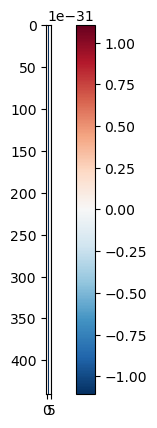

In [5]:
scale = np.max(np.abs(model.jacobian))

plt.imshow(model.jacobian, vmin=-scale, vmax=scale, cmap="RdBu_r")
plt.colorbar()